# Ví dụ 1

Tạo một bộ dữ liệu có 200 mẫu (N=200) phân đều vào 02 lớp – mỗi lớp 100 phần tử. Mỗi mẫu có 2 chiều (d=2).
Tiếp theo xây dựng các phương thức cần thiết cho phương pháp Soft Margin Vector Machine

## Cách 1: Tự xây dựng các bước giải bài toán ràng buộc

In [1]:
# generate data
# list of points
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

In [21]:
X.shape

(2, 20)

In [23]:
X

array([[2.05084632, 1.76011705, 2.00990941, 2.15538393, 1.43875123,
        1.99943406, 1.34862014, 1.75423984, 1.86131058, 2.6234161 ,
        4.75215781, 4.67253811, 4.68638834, 3.48737994, 4.07611593,
        2.95252573, 5.08269415, 3.52036329, 3.79891756, 2.7       ],
       [2.00111793, 1.19808615, 1.24470291, 2.05048046, 1.43310473,
        2.61376623, 1.04038789, 1.55383645, 1.97634695, 2.65203976,
        1.30969881, 0.78518512, 1.79005378, 0.86846079, 1.38790279,
        0.47959209, 1.30126272, 1.07691292, 1.22491879, 2.        ]])

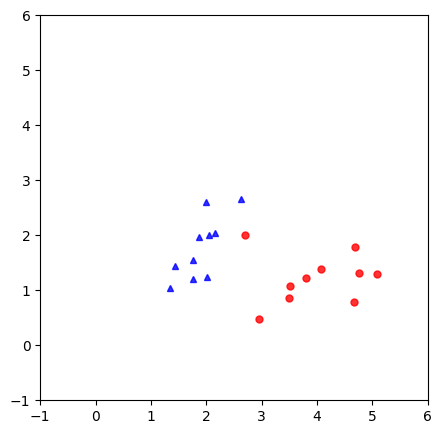

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))

ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

In [3]:
from cvxopt import matrix, solvers
C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.26997770e-08 7.29907090e-09 6.75263620e+00 1.20067067e-08
  8.83482181e-09 1.00135373e-08 9.49241066e-09 1.10095260e-08
  1.09448265e-08 1.15277180e+01 3.06483278e-09 2.92217775e-09
  3.52341246e-09 5.49363383e-09 4.48478627e-09 7.55953464e-09
  2.73325320e-09 5.71296652e-09 5.02756847e-09 1.82803543e+01]]


In [4]:
S = np.where(l > 1e-5)[0] # support set
S2 = np.where(l < .999*C)[0]

M = [val for val in S if val in S2] # intersection of two lists

M

[2, 9, 19]

In [5]:
print(y)

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1.]]


In [6]:
XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[0][M]

In [7]:
yM

array([ 1.,  1., -1.])

In [8]:
yM.shape

(3,)

In [9]:
XT.shape

(20, 2)

In [10]:
print(XT)

[[2.05084632 2.00111793]
 [1.76011705 1.19808615]
 [2.00990941 1.24470291]
 [2.15538393 2.05048046]
 [1.43875123 1.43310473]
 [1.99943406 2.61376623]
 [1.34862014 1.04038789]
 [1.75423984 1.55383645]
 [1.86131058 1.97634695]
 [2.6234161  2.65203976]
 [4.75215781 1.30969881]
 [4.67253811 0.78518512]
 [4.68638834 1.79005378]
 [3.48737994 0.86846079]
 [4.07611593 1.38790279]
 [2.95252573 0.47959209]
 [5.08269415 1.30126272]
 [3.52036329 1.07691292]
 [3.79891756 1.22491879]
 [2.7        2.        ]]


In [11]:
XM = XT[M]

print(XM)
print(XM.shape)

[[2.00990941 1.24470291]
 [2.6234161  2.65203976]
 [2.7        2.        ]]
(3, 2)


In [12]:
w_dual = VS.dot(lS)
print(w_dual)
print(w_dual.shape)

[[-5.54276837]
 [ 2.41628387]]
(2, 1)


In [13]:
# w_dual = VS.dot(lS).reshape(-1, 1)

r = w_dual.T.dot(XM.T).T

b_dual = np.mean(yM - r)
print(w_dual.T, b_dual)

[[-5.54276837  2.41628387]] 9.132906850859555


## Cách 2. Xây dựng phương pháp giải bài toán tối ưu không ràng buộc:

In [14]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
.5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps
    
        wm[i] -= eps
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g

w0 = np.random.randn(X0_bar.shape[0], 1)
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

Gradient different: 0.000000


In [15]:
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w

w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

iter 1 cost: 87.184655


C:\Users\Admin\AppData\Local\Temp\ipykernel_1240\2937714327.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 10001 cost: 1.430915
iter 20001 cost: 1.092201
iter 30001 cost: 0.779892
iter 40001 cost: 0.491327
iter 50001 cost: 0.218693
iter 60001 cost: 0.183223
iter 70001 cost: 0.183222
iter 80001 cost: 0.183221
iter 90001 cost: 0.183220
[[-5.54923267  2.41881653]] [9.14508377]


## Sử dụng thư viện

In [16]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C
# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-5.54202362  2.4156074 ]]
b =  [9.13241559]


## so sánh bộ trọng số tối ưu (kết quả) của cả ba phương pháp.

cả ba phương pháp trên đều cho ra kết quả gần giống nhau. trong đó phương pháp đầu tiên và thư viện có kết quả giống nhau nhất

# Bài tập tự thực hành 1
Sử dụng bộ trọng số W đã tính được và dự đoán các phân lớp y ứng với dữ liệu
X trên chính tập dữ liệu ngẫu nhiên vừa tạo. Đưa ra độ chính xác Accuracy và ma trận nhầm lẫn Confusion
Matrix theo mỗi phương pháp.

## Sử dụng bộ trọng số 1

In [25]:
print(w_dual.shape)
print(w_dual)
print(type(w_dual))

(2, 1)
[[-5.54276837]
 [ 2.41628387]]
<class 'numpy.ndarray'>


In [20]:
print(b_dual)

9.132906850859555


In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def predict(X, w, b):
    return np.sign(np.dot(w.T, X) + b).flatten()

# Dự đoán phân lớp
y_pred_dual = predict(X, w_dual, b_dual)

# Tính độ chính xác
accuracy_dual = accuracy_score(y.flatten(), y_pred_dual)

# Tạo ma trận nhầm lẫn
conf_matrix_dual = confusion_matrix(y.flatten(), y_pred_dual)

print("Accuracy:", accuracy_dual)
print("Confusion Matrix:")
print(conf_matrix_dual)

Accuracy: 1.0
Confusion Matrix:
[[10  0]
 [ 0 10]]


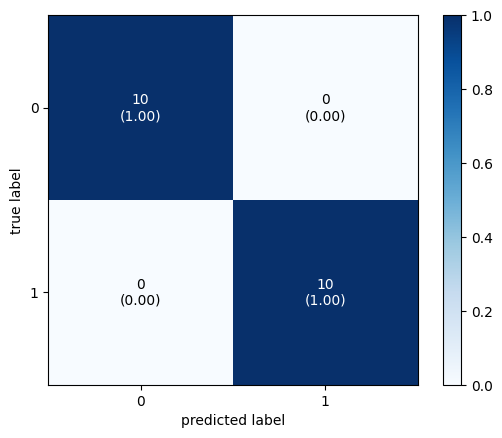

In [29]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_dual,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## Sử dụng bộ trọng số 2

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Dự đoán phân lớp
y_pred_hinge = predict(X, w_hinge, b_hinge)

# Tính độ chính xác
accuracy_hinge = accuracy_score(y.flatten(), y_pred_hinge)

# Tạo ma trận nhầm lẫn
conf_matrix_hinge = confusion_matrix(y.flatten(), y_pred_hinge)

print("Accuracy:", accuracy_hinge)
print("Confusion Matrix:")
print(conf_matrix_hinge)

Accuracy: 1.0
Confusion Matrix:
[[10  0]
 [ 0 10]]


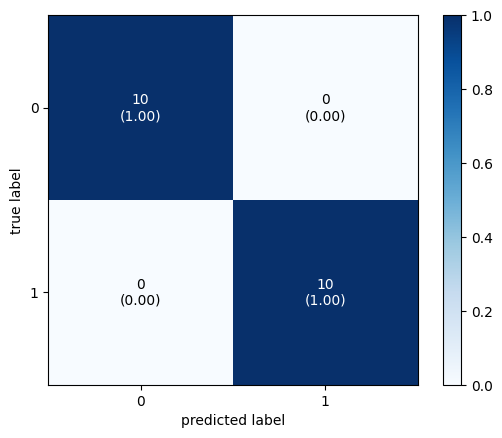

In [32]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_hinge,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## Sử dụng bộ trọng số thứ 3

In [34]:
# Dự đoán phân lớp
y_pred = predict(X, w.T, w0)

# Tính độ chính xác
accuracy = accuracy_score(y.flatten(), y_pred)

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(y.flatten(), y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 1.0
Confusion Matrix:
[[10  0]
 [ 0 10]]


In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# Ví dụ 2

In [53]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
connectionist_bench_sonar_mines_vs_rocks = fetch_ucirepo(id=151)

# data (as pandas dataframes)
X = connectionist_bench_sonar_mines_vs_rocks.data.features
y = connectionist_bench_sonar_mines_vs_rocks.data.targets

print(X.shape)
print(y.shape)

(208, 60)
(208, 1)


In [54]:
print(y)

    class
0       R
1       R
2       R
3       R
4       R
..    ...
203     M
204     M
205     M
206     M
207     M

[208 rows x 1 columns]


In [55]:
y = y.replace({'M': 1, 'R': -1})
y

C:\Users\Admin\AppData\Local\Temp\ipykernel_11340\3954369787.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'M': 1, 'R': -1})


,class
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
203,1
204,1
205,1
206,1


## Soft margin SVM thu vien

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Tạo mô hình SVM với soft margin, huấn luyện mô hình
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

# Dự đoán nhãn cho tập kiểm tra
y_pred = svm_model.predict(X_test)

# Đánh giá hiệu suất của mô hình bằng độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print("Độ chính xác của mô hình SVM là:", accuracy)

Độ chính xác của mô hình SVM là: 0.8571428571428571


e:\ML\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Ví dụ 3 (Bài tập tự giải): Lọc thư rác:

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml

# Load dataset
data = fetch_openml(name='spambase')

X = data.data
y = data.target

In [3]:
X

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.0,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78


In [4]:
X.shape

(4601, 57)

In [5]:
y

0       1
1       1
2       1
3       1
4       1
       ..
4596    0
4597    0
4598    0
4599    0
4600    0
Name: class, Length: 4601, dtype: category
Categories (2, object): ['0', '1']

In [6]:
y.shape

(4601,)

In [11]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 7:3
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

In [12]:
# Chuyển các giá trị trong y về nhãn -1 với 1
y_train = np.where(y_train == '0', -1, 1)
y_test = np.where(y_test == '0', -1, 1)

# Huấn luyện mô hình SVM soft margin với các giá trị C trong danh sách
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for C in C_values:
    svm_model = SVC(kernel='linear', C=C)
    svm_model.fit(X_train, y_train)

    # Predict
    y_pred_train = svm_model.predict(X_train)
    y_pred_test = svm_model.predict(X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"SVM model with C={C}:")
    print(f"   Training accuracy: {train_accuracy:.2f}")
    print(f"   Testing accuracy: {test_accuracy:.2f}")



SVM model with C=0.001:
   Training accuracy: 0.88
   Testing accuracy: 0.89
SVM model with C=0.01:
   Training accuracy: 0.92
   Testing accuracy: 0.91
SVM model with C=0.1:
   Training accuracy: 0.93
   Testing accuracy: 0.92
SVM model with C=1:
   Training accuracy: 0.93
   Testing accuracy: 0.93
SVM model with C=10:
   Training accuracy: 0.94
   Testing accuracy: 0.93
SVM model with C=100:
   Training accuracy: 0.94
   Testing accuracy: 0.93
SVM model with C=1000:
   Training accuracy: 0.93
   Testing accuracy: 0.93
SVM model with C=10000:
   Training accuracy: 0.93
   Testing accuracy: 0.93


## Nhan xet:
C càng lớn, thời gian thực thi mô hình càng lâu. Khi giá trị C tăng lên đến một ngưỡng nhất định, thì độ chĩnh xác trên tập kiểm tra và tập test cũng tăng lên. Cụ thể Khi tăng C = 10, C = 100 thì độ chính xác trên tập kiểm tra là 0.94, tập huấn luyện là 0.93. Tuy nhiên khi C = 1000, hay C = 10000 (hard margin) thì độ chính xác lại giảm về 0.93 trên cả 2 tập test và kiểm tra. Khi giá trị của C tăng đủ lớn, mô hình phân loại dữ liệu nghiêm ngặt hơn. Điều này dẫn đến sự cải thiện độ chính xác trên cả tập huấn luyện và tập kiểm tra.

Nguyên nhân của việc khi C tăng đến 1 ngưỡng nhất định mà độ chính xác không được cải thiện thêm là do dữ liệu không thể được phân chia một cách hoàn hảo bằng một ranh giới tuyến tính. Khi đó, việc tăng giá trị của C không gây ra sự cải thiện đáng kể trong độ chính xác trên tập kiểm tra vì mô hình không thể tạo ra một ranh giới tuyến tính tốt hơn. Một nguyên nhân khác là khi C lớn, biên quyết định của mô hình SVM có thể không thay đổi đáng kể so với khi C có giá trị nhỏ hơn, tức là các điểm dữ liệu hỗ trợ (support vectors) và ranh giới giữa các lớp dữ liệu không thay đổi nhiều, nên độ chính xác của mô hình không được cải thiện.